In [17]:
# Cell 1: Import Libraries and Define Functions
import os
import fitz
import spacy
from langchain.docstore.document import Document
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

# Load SpaCy English model for sentence tokenization
nlp = spacy.load("en_core_web_sm")

def spacy_sentence_tokenize(text: str) -> list:
    """
    Tokenize text into sentences using SpaCy.
    """
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]

def load_pdf_to_documents(pdf_path: str) -> list:
    """
    Extract text from each page of a PDF and return a list of Document objects.
    Cleans text to remove line breaks and hyphenation issues.
    """
    documents = []
    with fitz.open(pdf_path) as doc:
        for i, page in enumerate(doc):
            text = page.get_text()
            # Normalize text: remove hyphenated line breaks and extra newlines
            text = text.replace("-\n", "").replace("\n", " ").strip()
            if text:  # Skip empty pages
                documents.append(Document(page_content=text, metadata={"page": i}))
    return documents

def analyze_chunks(chunks: list):
    import matplotlib.pyplot as plt

    token_lengths = [len(chunk.page_content.split()) for chunk in chunks]
    
    print(f"Total Chunks: {len(token_lengths)}")
    print(f"Average Tokens per Chunk: {sum(token_lengths) / len(token_lengths):.2f}")
    print(f"Min Tokens: {min(token_lengths)}")
    print(f"Max Tokens: {max(token_lengths)}")

    plt.hist(token_lengths, bins=20)
    plt.title("Chunk Token Length Distribution")
    plt.xlabel("Token Count")
    plt.ylabel("Number of Chunks")
    plt.show()

def sentence_overlap_chunk(doc_text: str, max_tokens: int = 150, overlap_sent_count: int = 2) -> list:
    """
    Chunk a document based on sentences, with overlapping sentence context between chunks.
    """
    sentences = spacy_sentence_tokenize(doc_text)
    chunks = []
    current_chunk = []
    current_len = 0

    for sentence in sentences:
        token_count = len(sentence.split())
        if current_len + token_count <= max_tokens:
            current_chunk.append(sentence)
            current_len += token_count
        else:
            chunks.append(" ".join(current_chunk))
            # Start next chunk with sentence overlap
            current_chunk = current_chunk[-overlap_sent_count:] + [sentence]
            current_len = sum(len(s.split()) for s in current_chunk)

    if current_chunk:
        chunks.append(" ".join(current_chunk))
    return chunks

def build_vector_store(documents: list, max_tokens: int = 250, overlap_sent_count: int = 3,
                       model_name: str = "sentence-transformers/allenai-specter",
                       persist_directory: str = "../her2_faiss_db") -> FAISS:
    """
    Build a FAISS vector store from sentence-aware chunks and save it locally.
    """
    all_chunks = []
    for doc in documents:
        text = doc.page_content
        metadata = doc.metadata
        chunks = sentence_overlap_chunk(text, max_tokens=max_tokens, overlap_sent_count=overlap_sent_count)
        all_chunks.extend([Document(page_content=chunk, metadata=metadata) for chunk in chunks])

    analyze_chunks(all_chunks) 
    embedding_model = HuggingFaceEmbeddings(model_name=model_name)
    vectorstore = FAISS.from_documents(all_chunks, embedding_model)
    vectorstore.save_local(persist_directory)
    return vectorstore

def load_vector_store(model_name: str = "sentence-transformers/allenai-specter",
                      persist_directory: str = "../her2_faiss_db") -> FAISS:
    """
    Load an existing FAISS vector store from a local directory using the specified embedding model.
    """
    embedding_model = HuggingFaceEmbeddings(model_name=model_name)
    return FAISS.load_local(persist_directory, embedding_model, allow_dangerous_deserialization=True)

def query_vector_store(vectorstore: FAISS, query: str, k: int = 3):
    """
    Perform a similarity search on the vector store given a query string and return the top k documents.
    """
    return vectorstore.similarity_search(query, k=k)


Processing PDF and building vector store...
Total Chunks: 37
Average Tokens per Chunk: 218.38
Min Tokens: 38
Max Tokens: 250


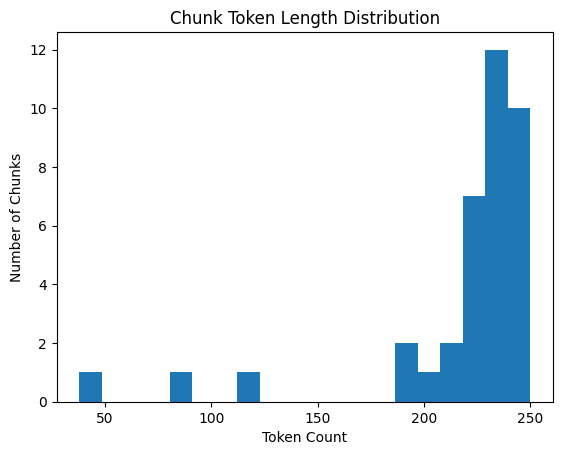

In [18]:
# Cell 2: Process the PDF and Build/Load the Vector Store
pdf_path = "../data/her2_paper.pdf"
persist_directory = "../her2_faiss_db"
force_rebuild = True  # Set to False to skip rebuilding if vector store exists

faiss_index_path = os.path.join(persist_directory, "index.faiss")

# Load or build the FAISS vector store
if not force_rebuild and os.path.exists(faiss_index_path):
    print("Loading existing vector store...")
    vectorstore = load_vector_store(persist_directory=persist_directory)
else:
    print("Processing PDF and building vector store...")
    documents = load_pdf_to_documents(pdf_path)
    vectorstore = build_vector_store(documents, persist_directory=persist_directory)


In [19]:
# Cell 3: Query the Vector Store
user_query = "What is the role of HER2 in breast cancer?"
results = query_vector_store(vectorstore, user_query, k=3)

print("\nQuery Results:")
for doc in results:
    page = doc.metadata.get("page", "Unknown")
    print(f"\n--- Page {page} ---")
    print(doc.page_content)



Query Results:

--- Page 5 ---
between HER-2/neu amplification and nodal status (P = 0.002) indicated that information on amplification of this gene may correlate with disease behavior; that is, recurrences and survival. To test this, univariate survival analyses were performed in which amplification was compared to relapse and survival in this patient group. A total of 35 patients had a recurrence ofthe disease, and 29 had died at the time of the analyses. Median times to relapse and death were 62 months and 69 months, respectively. The median follow-up time for patients still alive was 47 months, ranging from 24 to 86 months. A total of 71 of the 86 patients (83%) received some form of therapy after mastectomy: adjuvant systemic therapy alone, 47%; adjuvant systemic therapy plus local radiation, 19%; and local radiation alone, 17%. A strong and highly statistically significant correlation was found between the degree of gene amplification and both time to disease relapse (P = <0.000